# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [316]:
import random
import heapq 

In [317]:
import sys
!{sys.executable} -m pip install sortedcontainers
from sortedcontainers import SortedSet,SortedList

### Zapis i odczyt do pliku

In [318]:
def save_as_file(plot, name):
    with open(name+'.json', 'w') as file:
        file.write(plot.toJson())  

# save_as_file(plot,"p")

In [319]:
def read_file(file):
    with open(file, 'r') as file:
        json = file.read()
    return json

# json = read_file("p.json")
# plot2 = Plot(json=json)
# plot2.draw()

## Generowanie danych

### 1. Losowe generowanie odcinków

In [320]:
def generate_segments(num, x_to, y_to):
    segments = []
    points = []
    for _ in range(num):
        a = (random.uniform(0, x_to), random.uniform(0, y_to))
        b = (random.uniform(0, x_to), random.uniform(0, y_to))
        
        if a[0] == b[0]:
            i -= 1
        if a in points or b in points:
            i -= 1
        
        if a[0] < b[0]:
            segments.append((a,b))
        else:
            segments.append((b,a))
            
        points.append(a)
        points.append(b)

    return segments

<IPython.core.display.Javascript object>


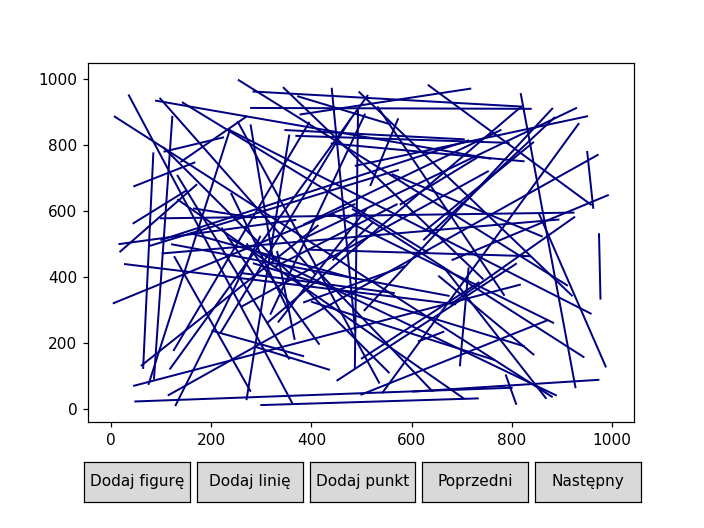

In [325]:
%matplotlib notebook
segments = generate_segments(100, 1000, 1000)
plot = Plot(points = [], 
            lines = [LinesCollection(segments, color = "navy", linewidth = 1.3)])
plot.draw()

In [326]:
# save_as_file(plot,"seg_random")

In [327]:
# json = read_file("seg_random.json")
# plot2 = Plot(json=json)
# plot2.draw()

### 2. Interaktywne zadawanie odcinków

<IPython.core.display.Javascript object>


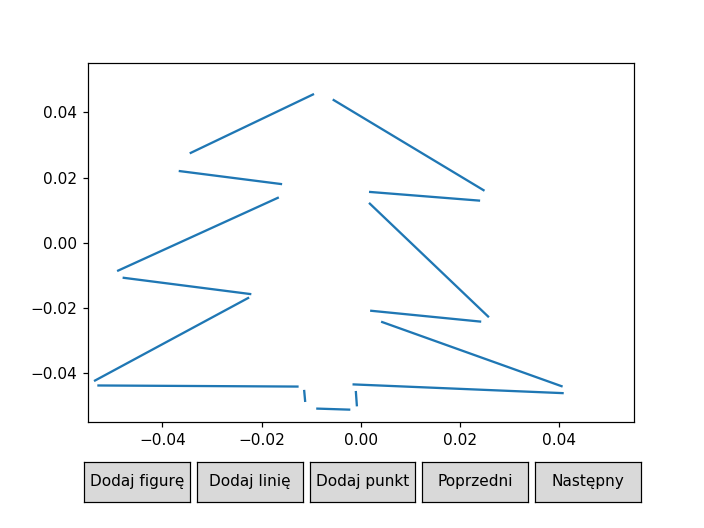

In [329]:
# odcinki zadawane za pomocą myszki
plot1 = Plot(scenes=[Scene()])
plot1.draw()

In [330]:
# narysowane linie

# added_lines = plot.get_added_lines()

def get_lines(added_lines):
    l = added_lines[0].lines
    lines = []
    for line in l:
        if line[0][0] < line[1][0]:
            lines.append((line[0],line[1]))
        else:
            lines.append((line[1],line[0]))
    return lines

In [331]:
# s = Plot([plot1.get_added_elements()])
# save_as_file(s,"seg_mouse")

In [332]:
# json = read_file("seg_mouse.json")
# plot2 = Plot(json=json)
# plot2.draw()

## Sprawdzanie czy istnieje para odcinków przecinających się

In [333]:
def det(a,b,c):
    return a[0]*b[1] + b[0]*c[1] + a[1]*c[0] - c[0]*b[1] - b[0]*a[1] - a[0]*c[1]

In [433]:
# położenie c względem wektora [a,b]
def orient(a,b,c,e = 10**-14):
    Det = det(a,b,c)
    
    if Det < -e:
        return "r"
    elif Det > e:
        return "l"
    else:
        return "c"

In [335]:
# sprawdza, czy 2 konkretne odcinki przecinają się
def seg_intersect(seg1,seg2):
    
    a = seg1[0]
    b = seg1[1]
    c = seg2[0]
    d = seg2[1]
    
    orient_ab_c = orient(a,b,c)
    orient_ab_d = orient(a,b,d)
    orient_cd_a = orient(c,d,a)
    orient_cd_b = orient(c,d,b)
    
    return orient_ab_c != orient_ab_d and orient_cd_a != orient_cd_b
    
    

In [336]:
# sprawdza, czy w zbiorze są min. 2 odcinki przecinające się

def check_if_any_intersect(segments,visualize = False):
    
    if visualize:
        scenes = [Scene([PointsCollection([])],
                [LinesCollection(segments,color = 'navy', linewidth = 1.3)]
                    )]
    
    # struktura zdarzeń uporządkowana po x - tablica (kopiec na razie niepotrzebny)
    events = []
    
    # miotła - struktura stanu uporządkowana po y - sortedset
    sweeper = SortedSet(key=lambda x: x[0][1])
    
    if visualize:
        max_y = float("-inf")
        min_y = float("inf")
    
    # segment [(x1,y1),(x2,y2)]
    for segment in segments:
        x1 = segment[0][0]
        x2 = segment[1][0]
        
        if visualize:
            y1 = segment[0][1]
            y2 = segment[1][1]
            max_y = max(max_y,max(y1,y2))
            min_y = min(min_y,min(y1,y2))
            
        if x1 < x2:
            events.append((segment[0][0], segment, 'start'))   
            events.append((segment[1][0], segment, 'end'))  
        else:
            events.append((segment[0][0], segment, 'end'))   
            events.append((segment[1][0], segment, 'start'))
            
    events.sort(key = lambda x: x[0])
        
    for event in events:

        if event[2] == 'start':
            
            if visualize:
                scenes.append(Scene([PointsCollection([event[1][0]],color = 'red')],
                    [LinesCollection(segments,color = 'navy', linewidth = 1.3),
                    LinesCollection([[(event[0],min_y),(event[0],max_y)]],color = 'red', linewidth = 2)]))
            
            segment = event[1]
            sweeper.add(segment)
            idx = sweeper.index(segment)
            
            pred_idx = idx-1
            succ_idx = idx+1
            
            if pred_idx >= 0:
                if seg_intersect(segment, sweeper[pred_idx]):
                    if visualize: return True,scenes
                    else: return True
                    
            if succ_idx < len(sweeper):
                if seg_intersect(segment,sweeper[succ_idx]):
                    if visualize: return True,scenes
                    else: return True
        
        
        
        elif event[2] == 'end':
            
            if visualize:
                scenes.append(Scene([PointsCollection([event[1][1]],color = 'red')],
                    [LinesCollection(segments,color = 'navy', linewidth = 1.3),
                    LinesCollection([[(event[0],min_y),(event[0],max_y)]],color = 'red', linewidth = 2)]))
            
            segment = event[1]
            
            pred_idx = idx-1
            succ_idx = idx+1
                        
            if pred_idx >= 0 and succ_idx < len(sweeper):
                if seg_intersect(sweeper[succ_idx], sweeper[pred_idx]):
                    status_set.remove(segment)
                    if visualize: return True,scenes
                    else: return True
                
            else: sweeper.remove(segment)
            
                    
    if visualize: return False,scenes
    else: return False

### Test - losowe

In [340]:
segments1 = generate_segments(5, 100, 100)

In [341]:
res,scenes = check_if_any_intersect(segments1,True)

True


<IPython.core.display.Javascript object>


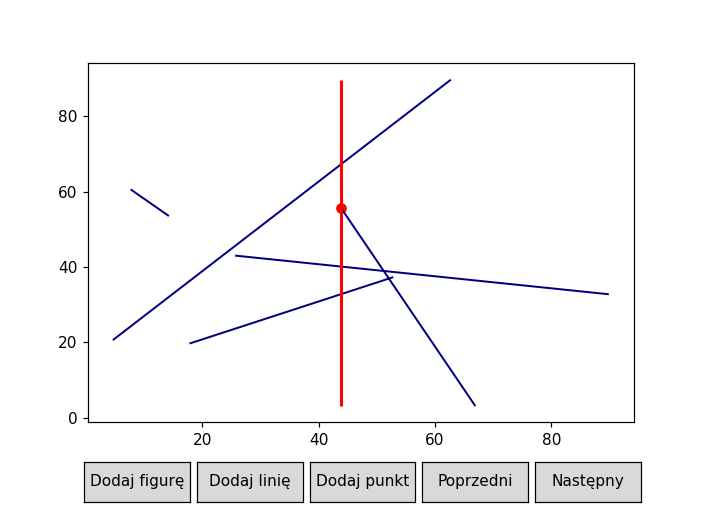

In [342]:
print(res)
plot1 = Plot(scenes=scenes)
plot1.draw()

### Test - zadawane myszką

<IPython.core.display.Javascript object>


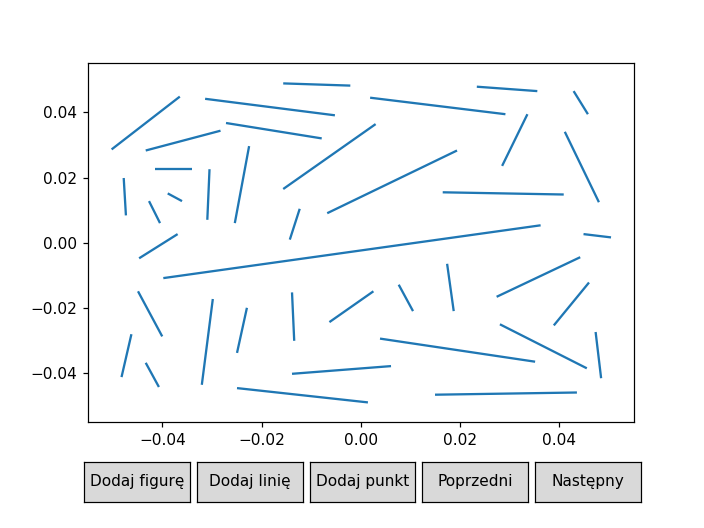

In [343]:
plot1 = Plot(scenes=[Scene()])
plot1.draw()

In [344]:
s = plot1.get_added_lines()

In [345]:
s1 = get_lines(s)

In [346]:
res,scenes = check_if_any_intersect(s1,True)

False


<IPython.core.display.Javascript object>


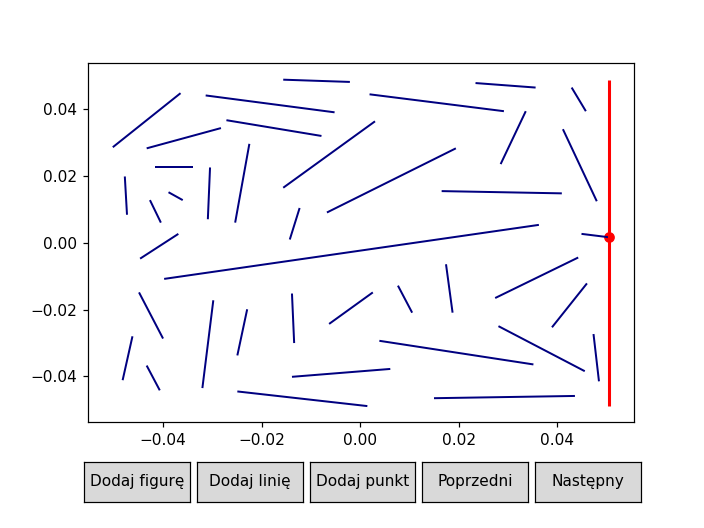

In [347]:
print(res)
plot1 = Plot(scenes=scenes)
plot1.draw()

## Wyznaczanie wszystkich przecięć w danym zbiorze

In [348]:
# porównujemy względem y dla danej współrzędnej x
class Segment:
    def __init__(self,segment):
        self.segment = segment
        self.start = segment[0]
        self.end = segment[1]
        # y = ax + b
        self.a =  (self.end[1] - self.start[1])/ (self.end[0] - self.start[0])
        self.b = self.start[1] - (self.a * self.start[0])
        
    def __hash__(self):
        return hash(self.a) ^ hash(self.b)
    
    def __eq__(self, other):
        return self.start == other.start and self.end == other.end
    
    def __lt__(self, other):
        x = Segment.x_comp
        return self.a * x + self.b < other.a * x + other.b
    
    def __gt__(self, other):
        x = Segment.x_comp
        print(x)
        return self.a * x + self.b > other.a * x + other.b
    
    def __str__(self):
        return ("[" + str(self.start) + str(self.end) + "]")
    
    def order(x):
        # współrzędna, po której porównujemy
        Segment.x_comp = x   

In [349]:
# dodaje przecięcie odcinków
def add_cross_event(events,segment1,segment2):
    seg1 = segment1.segment
    seg2 = segment2.segment
    
    x = (segment2.b - segment1.b)/(segment1.a - segment2.a)
    y = segment1.a * x + segment1.b
    
    event = (x, y, seg1, seg2, 'cross')
    
    heapq.heappush(events,event)

In [350]:
def find_intersections(segments,visualize = False):
    
    if visualize:
        scenes = [Scene([PointsCollection([])],
                [LinesCollection(segments,color = 'navy', linewidth = 1.3)]
                    )]
    
    # struktura zdarzeń uporządkowana po x - kopiec 
    events = []
    
    # miotła - struktura stanu uporządkowana po y - sortedset
    sweeper = SortedSet()
    
    # punkty przecięć, które kiedykolwiek znalazły się w strukturze zdarzeń
    cross_points = set()

    res = []
    
    if visualize:
        max_y = float("-inf")
        min_y = float("inf")
    
    # segment [(x1,y1),(x2,y2)]
    for segment in segments:
        x1 = segment[0][0]
        x2 = segment[1][0]
        
        if visualize:
            y1 = segment[0][1]
            y2 = segment[1][1]
            max_y = max(max_y,max(y1,y2))
            min_y = min(min_y,min(y1,y2))
            
        if x1 < x2:
            events.append((segment[0][0], segment, 'start'))   
            events.append((segment[1][0], segment, 'end'))  
        else:
            events.append((segment[0][0], segment, 'end'))   
            events.append((segment[1][0], segment, 'start'))
            
    Segment.order(events[-1][0])        
            
    heapq.heapify(events)
    
    
    while events != []:
        
        event = heapq.heappop(events)
        
        if event[-1] == 'start':
            
            if visualize:
                scenes.append(Scene([PointsCollection([event[1][0]],color = 'darkorange'),
                                    PointsCollection([i[0] for i in res],color = 'magenta',s=50)],
                    [LinesCollection(segments,color = 'navy', linewidth = 1.3),
                    LinesCollection([[(event[0],min_y),(event[0],max_y)]],color = 'darkorange', linewidth = 1.7)]))
            
        
            Segment.order(event[0])   # położenie miotły w danym x
             
            segment = event[1]
            s = Segment(segment)
            sweeper.add(s)
            idx = sweeper.index(s)
            
            pred_idx = idx-1
            succ_idx = idx+1
            
            if pred_idx >= 0:
                if seg_intersect(segment, sweeper[pred_idx].segment):
                    add_cross_event(events,s, sweeper[pred_idx])
                    
            if succ_idx < len(sweeper):
                if seg_intersect(segment,sweeper[succ_idx].segment):
                    add_cross_event(events,s,sweeper[succ_idx])
        
        elif event[-1] == 'end':
            
            if visualize:
                scenes.append(Scene([PointsCollection([event[1][1]],color = 'darkorange'),
                                    PointsCollection([i[0] for i in res],color = 'magenta',s=50)],
                    [LinesCollection(segments,color = 'navy', linewidth = 1.3),
                    LinesCollection([[(event[0],min_y),(event[0],max_y)]],color = 'darkorange', linewidth = 1.7)]))
                        
            segment = event[1]
            s = Segment(segment)
            sweeper.add(s)
           
            idx = sweeper.index(s)
            
            pred_idx = idx-1
            succ_idx = idx+1
                        
            if pred_idx >= 0 and succ_idx < len(sweeper):
                if seg_intersect(sweeper[succ_idx].segment, sweeper[pred_idx].segment):
                    add_cross_event(events, sweeper[succ_idx],sweeper[pred_idx])
            sweeper.discard(s)
                      
        elif event[-1] == 'cross':
            if (event[0],event[1]) in cross_points:
#                 print("bylo",event[0],event[1])
                continue
    
            if visualize:
                scenes.append(Scene([PointsCollection([(event[0],event[1])],color = 'firebrick',s = 70),
                                    PointsCollection([i[0] for i in res],color = 'magenta',s=50)],
                    [LinesCollection(segments,color = 'navy', linewidth = 1.3),
                    LinesCollection([[(event[0],min_y),(event[0],max_y)]],color = 'darkorange', linewidth = 1.7)]))
            
            
            # (x,y)
            cross_points.add((event[0],event[1]))
            res.append(((event[0],event[1]),event[2],event[3]))
                        
            seg1 = Segment(event[2])
            seg2 = Segment(event[3])
            
            # usuwam i dodaję z powrotem odcinki w odwróconym porządku
            sweeper.discard(seg1)
            sweeper.discard(seg2)
            
            Segment.order(event[0] + 10**-4)
            
            sweeper.add(seg1)
            sweeper.add(seg2)
            
            # potencjalnie nowy sąsiad poniżej
            idx1 = min(sweeper.index(seg1),sweeper.index(seg2)) 
            # potencjalnie nowy sąsiad powyżej
            idx2 = max(sweeper.index(seg1),sweeper.index(seg2))
            ngh1 = idx1-1
            if ngh1 >= 0 and ngh1 < len(sweeper)-1 and ngh1 != idx2:
                if seg_intersect(sweeper[ngh1].segment, sweeper[idx1].segment):
                    add_cross_event(events, sweeper[ngh1],sweeper[idx1])
                    
            ngh2 = idx2+1
            if ngh2 > 0 and ngh2 < len(sweeper) and ngh2 != idx1:
                if seg_intersect(sweeper[ngh2].segment, sweeper[idx2].segment):
                    add_cross_event(events, sweeper[ngh2],sweeper[idx2])

    if visualize:
        scenes.append(Scene([PointsCollection([i[0] for i in res],color = 'magenta',s=50)],
                    [LinesCollection(segments,color = 'navy', linewidth = 1.3)]))
            
        return scenes,res
    else: 
        return res

In [351]:
def print_res(res):
    for r in res:
        print("cross: ",r[0])
        print("line 1: ",r[1])
        print("line 2: ",r[2])
        print()

### Test - losowe

### 1. 

In [358]:
segments = generate_segments(10, 1000, 1000)

In [359]:
scenes,res = find_intersections(segments,True)
print_res(res)

cross:  (180.11696290851827, 676.6968078471541)
line 1:  ((163.19030365355601, 918.8170331207895), (225.99451013273742, 20.460872473589077))
line 2:  ((154.79663403907074, 688.7515361372958), (428.6994305026193, 558.3494467212231))

cross:  (184.15213294157837, 618.9774278616728)
line 1:  ((149.1789086631078, 641.2209061337298), (339.79750907136975, 519.9847094745256))
line 2:  ((163.19030365355601, 918.8170331207895), (225.99451013273742, 20.460872473589077))

cross:  (220.71575467993694, 95.96859317292287)
line 1:  ((203.11316480050147, 78.21970375943876), (912.3892518015434, 793.3907619977147))
line 2:  ((163.19030365355601, 918.8170331207895), (225.99451013273742, 20.460872473589077))

cross:  (301.4315946063319, 177.35528266477706)
line 1:  ((229.71599581219516, 182.22292829001253), (581.2172002351539, 158.3650322570187))
line 2:  ((203.11316480050147, 78.21970375943876), (912.3892518015434, 793.3907619977147))

cross:  (556.3626441931466, 434.40512806655624)
line 1:  ((400.304175

7


<IPython.core.display.Javascript object>


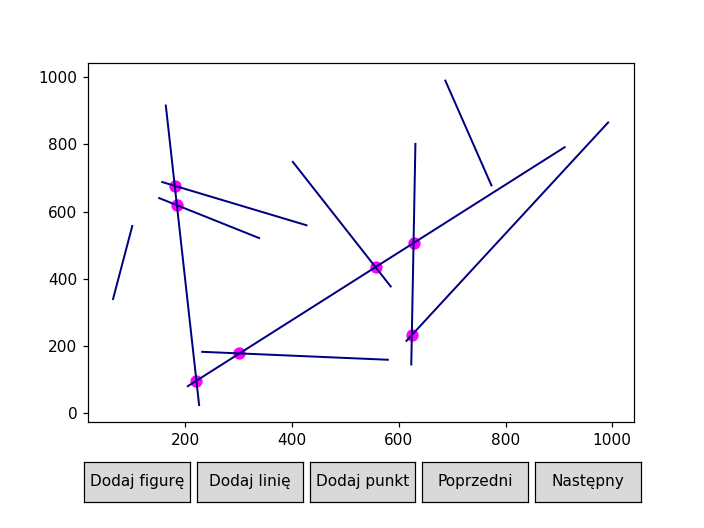

In [360]:
print(len(res))
plot1 = Plot(scenes=scenes)
plot1.draw()

### 2.

In [423]:
segments2 = generate_segments(20, 100, 100)

In [424]:
scenes2,res = find_intersections(segments2,True)

46


<IPython.core.display.Javascript object>


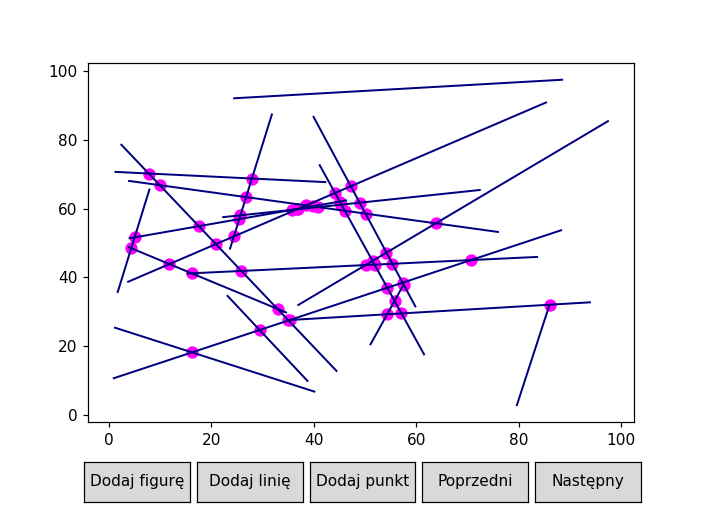

In [425]:
print(len(res))
plot1 = Plot(scenes=scenes2)
plot1.draw()

### Test - zadawane myszką

### 1.

<IPython.core.display.Javascript object>


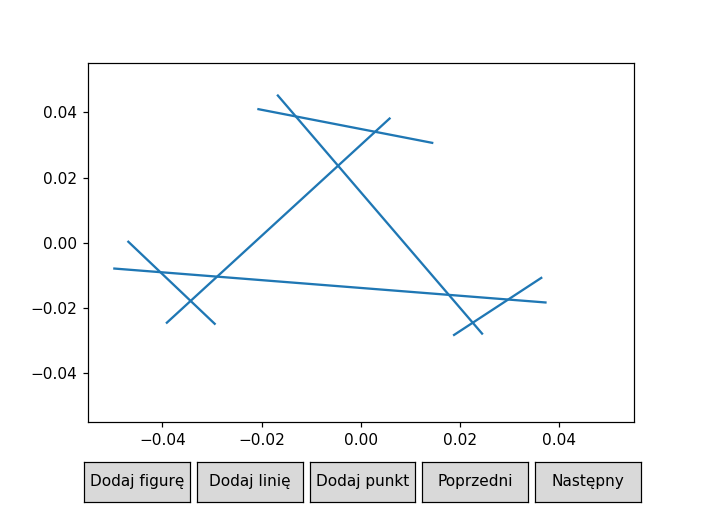

In [264]:
plot1 = Plot(scenes=[Scene()])
plot1.draw()

In [265]:
s = plot1.get_added_lines()
s1 = get_lines(s)

In [287]:
scenes,res = find_intersections(s1,True)
print_res(res)

cross:  (-0.04040962755886752, -0.00897441612879099)
line 1:  ((-0.04703313704459899, 0.0005874639866399745), (-0.029291201560728015, -0.025025281111399247))
line 2:  ((-0.04991620156072802, -0.007837781111399239), (0.03746283069733651, -0.01828508503296787))

cross:  (-0.03431082281648838, -0.017778818073058908)
line 1:  ((-0.039271040270405434, -0.02468827130747768), (0.005970895213465541, 0.038332562025855665))
line 2:  ((-0.04703313704459899, 0.0005874639866399745), (-0.029291201560728015, -0.025025281111399247))

cross:  (-0.02897197113423061, -0.010341937257495588)
line 1:  ((-0.04991620156072802, -0.007837781111399239), (0.03746283069733651, -0.01828508503296787))
line 2:  ((-0.039271040270405434, -0.02468827130747768), (0.005970895213465541, 0.038332562025855665))

cross:  (-0.013110111676714192, 0.03874577361331362)
line 1:  ((-0.016871846722018337, 0.04540976790820861), (0.02459992747153006, -0.028058369346693368))
line 2:  ((-0.020863782205889303, 0.04102864045722823), (0.01

9


<IPython.core.display.Javascript object>


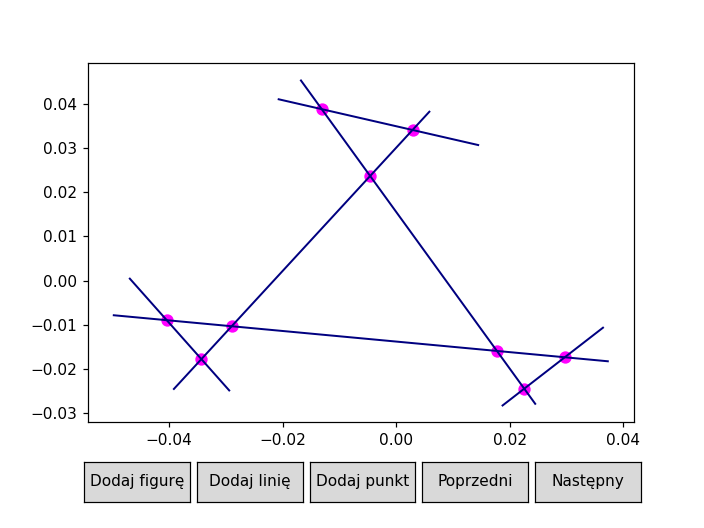

In [288]:
print(len(res))
plot1 = Plot(scenes=scenes)
plot1.draw()

### 2.

<IPython.core.display.Javascript object>


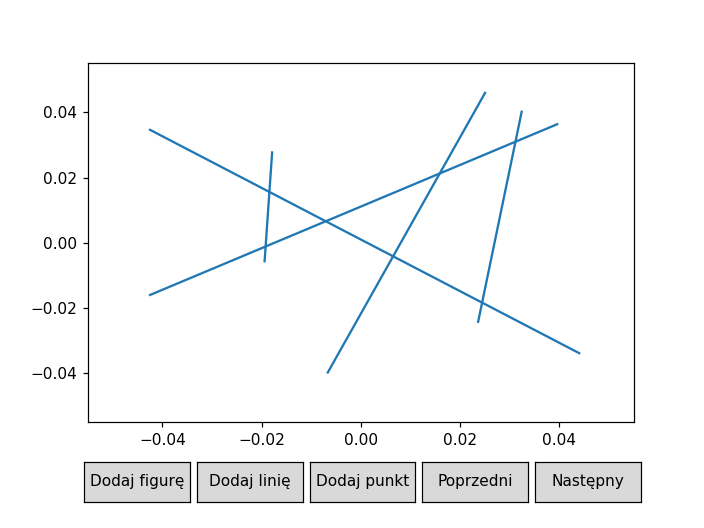

In [453]:
plot2 = Plot(scenes=[Scene()])
plot2.draw()

In [454]:
s2 = plot2.get_added_lines()
s3 = get_lines(s2)

In [455]:
scenes,res = find_intersections(s3,True)
print_res(res)

cross:  (-0.01919003342529712, -0.0011079206383018403)
line 1:  ((-0.019412172379032262, -0.005978488314385411), (-0.01785975302419355, 0.028059501881693025))
line 2:  ((-0.04269846270161291, -0.016088782432032475), (0.039801537298387105, 0.03648474697973225))

cross:  (-0.018427737170400752, 0.015606011953298455)
line 1:  ((-0.04269846270161291, 0.0347996979601244), (0.04423702116935485, -0.033950302039875625))
line 2:  ((-0.019412172379032262, -0.005978488314385411), (-0.01785975302419355, 0.028059501881693025))

cross:  (-0.007064049391630423, 0.006619422128250488)
line 1:  ((-0.04269846270161291, -0.016088782432032475), (0.039801537298387105, 0.03648474697973225))
line 2:  ((-0.04269846270161291, 0.0347996979601244), (0.04423702116935485, -0.033950302039875625))

cross:  (0.0065163709155235, -0.004120195971794707)
line 1:  ((-0.006771043346774197, -0.04001647851046386), (0.02516444052419356, 0.046258031293457735))
line 2:  ((-0.04269846270161291, 0.0347996979601244), (0.04423702116

7


<IPython.core.display.Javascript object>


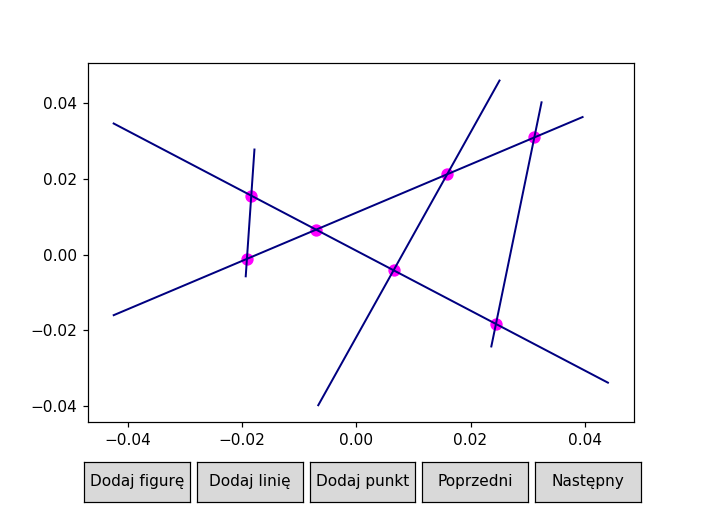

In [456]:
print(len(res))
plot1 = Plot(scenes=scenes)
plot1.draw()